In [3]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# Each person has at least 70 photos
# Reduce the size of the image to 40% of its original size

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1] #数据集中每个样本（在这里是图像）的特征数量
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0] #数据集中不同的类别或标签的数量
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [5]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
#原始数据降维到仅包含150个主成分

In [7]:
# Center data
mean = np.mean(X_train, axis=0) #数据中心化操作
X_train -= mean
X_test -= mean
#Eigen-decomposition 奇异值分解
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components] # Store variable
eigenfaces = components.reshape((n_components, h, w)) #重新形状为三维数组
#project into PCA subspace
X_transformed = np.dot(X_train, components.T) #投影到PCA子空间
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)


(966, 150)
(322, 150)


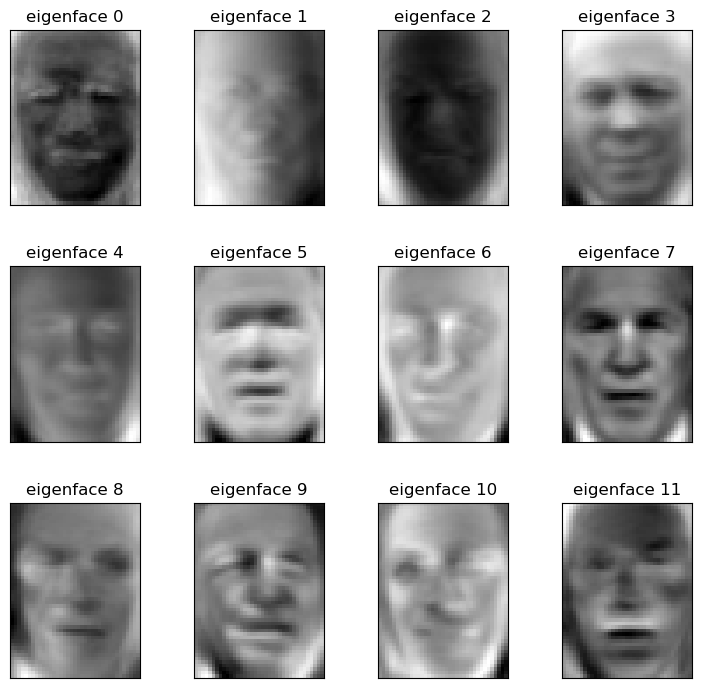

In [8]:
import matplotlib.pyplot as plt #可视化Eigenfaces（主成分）的图像
# Define a helper function to plot a gallery of portraits
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col): #迭代每个子图的索引
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


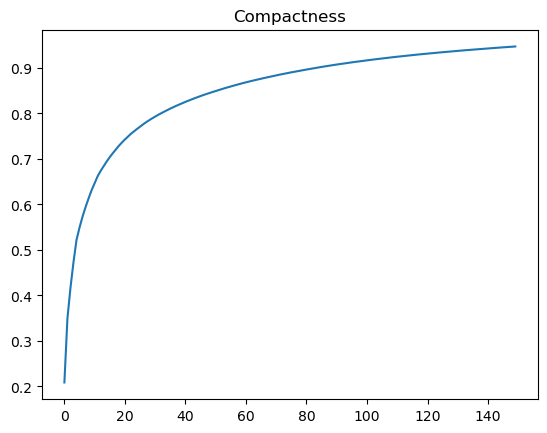

In [9]:
explained_variance = (S ** 2) / (n_samples - 1) #PCA降维后的每个主成分的方差
total_var = explained_variance.sum() #总方差代表了原始数据的总信息量
explained_variance_ratio = explained_variance / total_var #每个主成分的方差解释比例
ratio_cumsum = np.cumsum(explained_variance_ratio) # 方差解释比例的累积和
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components) #主成分的数量
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test # 计算了每个预测是否与测试数据的真实标签匹配
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 6 3 3 4 1 1 3 3 1 1 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 6 1 3 4 3 6 1 4 1 3 6 4 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 3 5 3 3 1 1 3 3 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 3 3 3 1 3 3 1 3
 6 1 1 3 1 3 3 3 6 1 3 3 6 6 5 1 3 3 5 1 3 3 1 3 3 1 5 3 3 3 3 5 3 3 3 3 3
 3 3 3 3 2 3 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 6 2 1 5 3 3 4 4 3 1 3 3 3 5
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 1 3 3 3 3 4 6 3 3 3 3 3 3 6 4 3 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 4 1 6 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 3
 3 5 3 3 3 6 6 3 1 3 3 3 1 3 3 3 1 3 1 3 3 3 3 3 5 3]
Which Correct: [ True  True False  True  True  True False  True  True  True  True  True
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

Z:\Conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
